In [1]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/FastaiNotebook_07_batchnorm")' FastaiNotebook_07_batchnorm
%install '.package(path: "$cwd/SwiftCV")' SwiftCV

Installing packages:
	.package(path: "/home/jmd/workspace/ml/fastai/nbs/swift/FastaiNotebook_07_batchnorm")
		FastaiNotebook_07_batchnorm
	.package(path: "/home/jmd/workspace/ml/fastai/nbs/swift/SwiftCV")
		SwiftCV
With SwiftPM flags: []
Working in: /tmp/tmpyhemr6vo/swift-install
/home/jmd/swift/usr/bin/swift-build: /home/jmd/anaconda3/lib/libcurl.so.4: no version information available (required by /home/jmd/swift/usr/lib/swift/linux/libFoundationNetworking.so)
[1/2] Compiling jupyterInstalledPackages jupyterInstalledPackages.swift
[2/3] Merging module jupyterInstalledPackages
Initializing Swift...
Installation complete!


In [2]:
//export
import Path
import TensorFlow
#if canImport(PythonKit)
    import PythonKit
#else
    import Python
#endif


In [3]:
import FastaiNotebook_07_batchnorm

In [4]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


In [5]:
//export
public let dataPath = Path.home/".fastai"/"data"

In [6]:
//export
public func downloadImagenette(path: Path = dataPath) -> Path {
    let url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette-160.tgz"
    let fname = "imagenette-160"
    let file = path/fname
    try! path.mkdir(.p)
    if !file.exists {
        downloadFile(url, dest:(path/"\(fname).tgz").string)
        _ = "/bin/tar".shell("-xzf", (path/"\(fname).tgz").string, "-C", path.string)
    }
    return file
}

In [7]:
let path = downloadImagenette()

In [8]:
for e in path.ls() { print("\(e.path) (\(e.kind == .directory ? "directory": "file"))")}

/home/jmd/.fastai/data/imagenette-160/val (directory)
/home/jmd/.fastai/data/imagenette-160/train (directory)


In [9]:
for e in (path/"val").ls() { print("\(e.path) (\(e.kind == .directory ? "directory": "file"))")}

/home/jmd/.fastai/data/imagenette-160/val/n02102040 (directory)
/home/jmd/.fastai/data/imagenette-160/val/n03445777 (directory)
/home/jmd/.fastai/data/imagenette-160/val/n03028079 (directory)
/home/jmd/.fastai/data/imagenette-160/val/n03425413 (directory)
/home/jmd/.fastai/data/imagenette-160/val/n03000684 (directory)
/home/jmd/.fastai/data/imagenette-160/val/n03417042 (directory)
/home/jmd/.fastai/data/imagenette-160/val/n03888257 (directory)
/home/jmd/.fastai/data/imagenette-160/val/n01440764 (directory)
/home/jmd/.fastai/data/imagenette-160/val/n02979186 (directory)
/home/jmd/.fastai/data/imagenette-160/val/n03394916 (directory)


In [10]:
let pathTench = path/"val"/"n01440764"

In [11]:
let imgFn = Path.home/".fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00006697.JPEG"
imgFn.string

"/home/jmd/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00006697.JPEG"


In [12]:
//export
import SwiftCV
import Foundation

In [13]:
//load the image in memory
let imgContent = Data(contentsOf: imgFn.url)
// make opencv image
var cvImg = imdecode(imgContent)
// convert to RGB
cvImg = cvtColor(cvImg, nil, ColorConversionCode.COLOR_BGR2RGB)

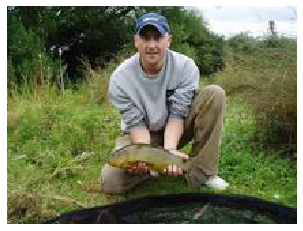

None


In [14]:
let tensImg = Tensor<UInt8>(cvMat: cvImg)!
let numpyImg = tensImg.makeNumpyArray()
plt.imshow(numpyImg) 
plt.axis("off")
plt.show()

In [15]:
//export
public func fetchFiles(path: Path, recurse: Bool = false, extensions: [String]? = nil) -> [Path] {
    var res: [Path] = []
    for p in try! path.ls(){
        if p.kind == .directory && recurse { 
            res += fetchFiles(path: p.path, recurse: recurse, extensions: extensions)
        } else if extensions == nil || extensions!.contains(p.path.extension.lowercased()) {
            res.append(p.path)
        }
    }
    return res
}

In [16]:
time { let fNames = fetchFiles(path: path, recurse: true, extensions: ["jpeg", "jpg"]) }

average: 1272.873771 ms,   min: 1272.873771 ms,   max: 1272.873771 ms


In [17]:
let fNames = fetchFiles(path: path, recurse: true, extensions: ["jpeg", "jpg"])

In [18]:
fNames.count == 13394

true


In [19]:
print(type(of: cvImg))

Mat


In [20]:
//export
public protocol ItemBase {
    func transform( _ tfms: [(inout Self) -> ()]) -> Self
}

In [21]:
public struct Image: ItemBase{
    
    public var path: Path
    public lazy var img: Mat = {
        //print("Load image in memory")
        return imdecode(try! Data(contentsOf: path.url))
    } ()
    
    public init(_ img: Mat, _ path: Path) {
        (self.path,self.img) = (path,img)
    }
    
    public init(_ path: Path) { self.path = path }
    
    public mutating func show(){
        let tensImg = Tensor<UInt8>(cvMat: img)!
        let numpyImg = tensImg.makeNumpyArray()
        plt.imshow(numpyImg) 
        plt.axis("off")
        plt.show()
    }
    
    public func transform(_ tfms: [(inout Image) -> ()]) -> Image{
        var tfmedImg = Image(path)
        tfms.forEach() { $0(&tfmedImg) }
        return tfmedImg
    }
    
    public mutating func toTensor() -> TF {
        return TF(Tensor<UInt8>(cvMat: img)!)
    }
}

In [22]:
var img = Image(imgFn)

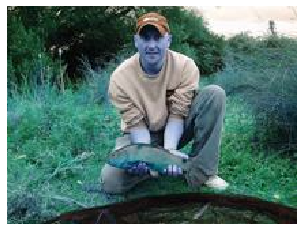

In [23]:
img.show()

In [24]:
// export
public struct ItemList<T> where T: ItemBase{
    public var items: [T]
    public let path: Path
    public var tfms: [(inout T) -> ()] = [] 
    
    public init(items: [T], path: Path, tfms: [(inout T) -> ()] = []){
        (self.items,self.path,self.tfms) = (items,path,tfms)
    }
    
    public init (_ il: ItemList<T>, newItems: [T]) {
        self.init(items: newItems, path: il.path, tfms: il.tfms)
    }
    
    public subscript(index: Int) -> T {
        return items[index].transform(tfms)
    }
}

In [25]:
// export
public protocol InitableFromPath {
    init(_ path: Path)
}
extension Image: InitableFromPath {}

In [26]:
// export
public extension ItemList where T: InitableFromPath {
    init(fromFolder path: Path, extensions: [String], recurse: Bool = true, tfms: [(inout T) -> ()] = []) {
        self.init(items: fetchFiles(path: path, recurse: recurse, extensions: extensions).map { T($0) },
                  path:  path,
                  tfms: tfms)
    }
}

In [27]:
let il: ItemList<Image> = ItemList(fromFolder: path, extensions: ["jpeg", "jpg"])

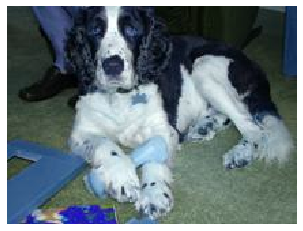

In [28]:
var img = il[0]
img.show()

In [29]:
func convertRGB(_ img: inout Image) {
    img.img = cvtColor(img.img, nil, ColorConversionCode.COLOR_BGR2RGB)
}

func resize(_ img: inout Image, size: Int) {
    img.img = resize(img.img, nil, Size(size, size), 0, 0, InterpolationFlag.INTER_AREA)
}

In [30]:
let il: ItemList<Image> = ItemList(fromFolder: path, extensions: ["jpeg", "jpg"],
                                  tfms: [convertRGB, { resize(&$0, size:128) }])

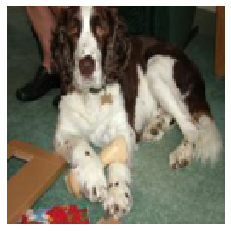

In [31]:
var img = il[0]
img.show()

In [32]:
// export
public struct SplitData<T> where T: ItemBase{
    public let train, valid: ItemList<T>
    public var path: Path { return train.path }
    
    public init(train: ItemList<T>, valid: ItemList<T>){
        (self.train, self.valid) = (train, valid)
    }
    
    public init(_ il: ItemList<T>, fromFunc: (T) -> Bool){
        self.init(train: ItemList(il, newItems: il.items.filter { !fromFunc($0) }),
                  valid: ItemList(il, newItems: il.items.filter {  fromFunc($0) }))
    }
}

In [33]:
// export
public func grandParentSplitter(fName: Path, valid: String = "valid") -> Bool{
    return fName.parent.parent.basename() == valid
}

In [34]:
let sd = SplitData(il) { grandParentSplitter(fName: $0.path, valid: "val") }

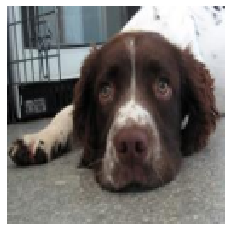

In [36]:
var img = sd.train[0]
img.show()

In [37]:
// export
public protocol Processor {
    associatedtype Input: ItemBase
    associatedtype Output: ItemBase
    
    mutating func initState(_ items: [Input])
    func process1(_ item: Input) -> Output
    func deprocess1(_ item: Output) -> Input
}

In [38]:
// export
public extension Processor {
    func process(_ items: [Input]) -> [Output] {
        return items.map { process1($0) }
    }
    
    func deprocess(_ items: [Output]) -> [Input] {
        return items.map { deprocess1($0) }
    }
}

In [39]:
// export
public struct NoopProcessor<Item>: Processor where Item: ItemBase{
    public init() {}
   
    public mutating func initState(_ items: [Item]) {}
    
    public func process1  (_ item: Item) -> Item { return item }
    public func deprocess1(_ item: Item) -> Item { return item }
}

In [40]:
//export
extension String: ItemBase {
    public func transform(_ tfms: [(inout String) -> ()]) -> (String) { return self }
}

extension Int: ItemBase {
    public func transform(_ tfms: [(inout Int) -> ()]) -> (Int) { return self }
}

In [41]:
// export
public struct CategoryProcessor: Processor {
    public init() {}
    public var vocab: [String]? = nil
    public var reverseMap: [String: Int]? = nil
    
    public mutating func initState(_ items: [String]) {
        vocab = Array(Set(items)).sorted()
        reverseMap = [:]
        for (i,x) in vocab!.enumerated() { reverseMap![x] = i }
    }
    
    public func process1  (_ item: String) -> Int { return reverseMap![item]! }
    public func deprocess1(_ item: Int) -> String { return vocab![item] }
}

In [42]:
public struct LabeledItemList<I, L> where I:ItemBase, L: ItemBase{
    public var inputs: ItemList<I>
    public var labels: ItemList<L>
    public var path: Path { return inputs.path }
    
    public init(inputs: ItemList<I>, labels: ItemList<L>) {
        (self.inputs,self.labels) = (inputs,labels)
    }
    
    public subscript(_ i: Int) -> (I, L) {
        return (inputs[i], labels[i])
    }
}

public extension LabeledItemList {
    init(_ il: ItemList<I>, labelWithFunc f: @escaping (I) -> L) {
        self.init(inputs: il, labels: ItemList(items: il.items.map{ f($0) }, path: il.path, tfms: []))
    }
}

In [43]:
public func parentLabeler(_ fName: Path) -> String { return fName.parent.basename() }

In [44]:
let ll = LabeledItemList(il, labelWithFunc: { parentLabeler($0.path) })

n02102040


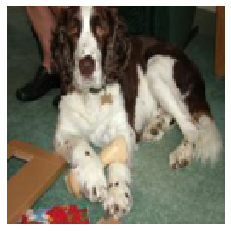

In [45]:
var x = ll[0]
x.0.show()
print(x.1)

In [46]:
public func process<PI> (_ il: ItemList<PI.Input>, proc: PI) -> ItemList<PI.Output> where PI: Processor {
    return ItemList(items: proc.process(il.items), path: il.path, tfms: [])
}

In [47]:
public func process<PI, PL> (_ lil: LabeledItemList<PI.Input, PL.Input>, procInp: PI, procLab: PL) 
-> LabeledItemList<PI.Output, PL.Output> where PI: Processor, PL: Processor {
    return LabeledItemList(
        inputs: process(lil.inputs, proc: procInp),
        labels: process(lil.labels, proc: procLab)
    )
}

In [48]:
public struct SplitLabeledData<PI, PL> where PI: Processor, PL: Processor{
    public var train, valid: LabeledItemList<PI.Output, PL.Output>
    public var path: Path { return train.path }
    public var procInp: PI
    public var procLab: PL
    
    public init(_ rawTrain: LabeledItemList<PI.Input,PL.Input>, 
                _ rawValid: LabeledItemList<PI.Input,PL.Input>,
                procInp: inout PI,
                procLab: inout PL) {
        procInp.initState(rawTrain.inputs.items)
        procLab.initState(rawTrain.labels.items)
        train = process(rawTrain, procInp: procInp, procLab: procLab)
        valid = process(rawValid, procInp: procInp, procLab: procLab)
        (self.procInp,self.procLab) = (procInp,procLab)
    }
}

In [49]:
public extension SplitLabeledData {
    init(_ sd: SplitData<PI.Input>, 
         labelWithFunc f: @escaping (PI.Input) -> PL.Input,
         procInp: inout PI,
         procLab: inout PL) {
        self.init(LabeledItemList(sd.train, labelWithFunc: f),
                  LabeledItemList(sd.valid, labelWithFunc: f),
                  procInp: &procInp,
                  procLab: &procLab)
    }
}

In [50]:
var procInp = NoopProcessor<Image>()
var procLab = CategoryProcessor()

In [51]:
var sld = SplitLabeledData(sd, labelWithFunc: { parentLabeler($0.path) }, procInp: &procInp, procLab: &procLab)

n02102040


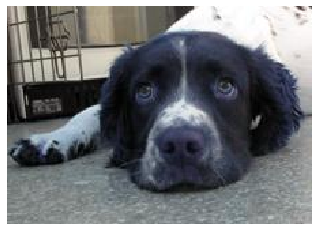

In [52]:
var x = sld.train[0]
x.0.show()
print(sld.procLab.deprocess1(x.1))

In [53]:
sld.train.inputs.tfms = [convertRGB, { resize(&$0, size:128) }]

n02102040


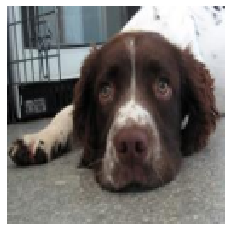

In [54]:
var x = sld.train[0]
x.0.show()
print(sld.procLab.deprocess1(x.1))

In [55]:
public extension SplitLabeledData{
    mutating func transform(_ tfms: ([(inout PI.Output) -> ()], [(inout PI.Output) -> ()])){
        train.inputs.tfms = tfms.0
        valid.inputs.tfms = tfms.1
    }
}

In [56]:
var sld = SplitLabeledData(sd, labelWithFunc: { parentLabeler($0.path) }, procInp: &procInp, procLab: &procLab)
let tfms = [convertRGB, { resize(&$0, size:512) }]
sld.transform((tfms, tfms))

n02102040


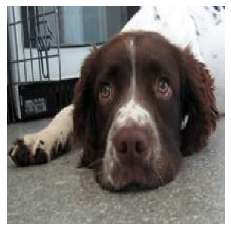

In [57]:
var x = sld.train[0]
x.0.show()
print(sld.procLab.deprocess1(x.1))

In [58]:
func loadSync(_ n: Int) -> TF {
    var imgs: [TF] = []
    for i in 1...n { 
        var img = sld.train[i].0
        imgs.append(img.toTensor().expandingShape(at: 0) / 255.0)
    }
    return TF(concatenating: imgs, alongAxis: 0)
}

In [59]:
time { let imgs = loadSync(100) }

average: 2660.589927 ms,   min: 2660.589927 ms,   max: 2660.589927 ms


In [60]:
func loadQSync(_ n: Int) -> [Image] {
    var imgs: [Image] = []
    let queue = DispatchQueue(label: "myqueue")
    queue.sync {
        for i in 1...n { imgs.append(sld.train[i].0) }
    }
    return imgs
}